# Hospital - Error Detection using GRUs


In [1513]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import h5py
import pickle
from sklearn.model_selection import train_test_split
from numpy.random import seed
import time 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import models
from keras import layers
from keras import optimizers
from keras import activations
from keras import losses
from keras import metrics
from keras.utils import to_categorical
from keras.models import load_model

import matplotlib.pyplot as plt
%matplotlib inline

In [1514]:
seed(42)

## Read the data

In [1515]:
#df = pd.read_csv('train_test_hosp_dataset.csv', encoding='utf8',dtype=object)

In [1516]:
df = pd.read_csv('hospital_final_train.csv', encoding='utf8',dtype=object)
df = df.sample(frac=1)

In [1517]:
df.head(3)

,ProviderNumber,HospitalName,Address1,City,State,ZipCode,CountyName,PhoneNumber,HospitalType,HospitalOwner,EmergencyService,Condition,MeasureCode,MeasureName,Score,Sample,Stateavg,label
521,10023,baptist medical center south,2105 east south boulevard,montgomery,al,36116,montgomery,3342882100,acute care hospitals,voluntary non-profit - church,yxs,heart attack,ami-7a,heart attack patients given fibrinolytic medic...,empty,0 patients,al_ami-7a,0
737,10035,cullman regional medical center,1912 alabaxa highway 157,cullman,al,35058,cullman,2567372000,acute care hospitals,government - hospital district or authority,yes,surgical infection prevention,scip-inf-4,all heart surgery patients whose blood sugar (...,empty,0 patients,al_scip-inf-4,0
740,10035,cullman regional medical center,1912 alabama highway 157,cullman,al,35058,cullman,2567372000,acute care hospitals,government - hospital district or authority,yes,surgical infection prevention,scip-vte-2,patients who got treatment at the right time ...,95%,298 patients,al_scip-vte-2,1


In [1518]:
df['label'].value_counts()

1    699
0    301
Name: label, dtype: int64

### Separate the labels from the training data

In [1519]:
start = time.time()

In [1520]:
df['label'] = df['label'].apply(lambda x: int(float(x)))
labels = np.asarray(df['label'].tolist())

In [1521]:
dftestList = df.values.tolist()

In [1522]:
df.drop(columns=['label'], axis=1, inplace=True)

In [1523]:
df.shape

(1000, 17)

### Convert each row to a space separated string

In [1524]:
dfList = df.values.tolist()

In [1525]:
dfCol = df.columns.tolist()
dfCol.append('label')

In [1526]:
rows = []
for rownum in range(len(dfList)):
    combined = ':'.join([str(x) for x in dfList[rownum]])
    rows.append(combined)

In [1527]:
testSet= []
labels_test = []
for i in range(int(0.7*len(dfList)), len(dfList)):
    combined = ':'.join([str(x) for x in dfList[i]])
    testSet.append(combined)
    labels_test.append(labels[i])
index = np.arange(len(testSet))

In [1528]:
rows[0]

'10023:baptist medical center south:2105 east south boulevard:montgomery:al:36116:montgomery:3342882100:acute care hospitals:voluntary non-profit - church:yxs:heart attack:ami-7a:heart attack patients given fibrinolytic medication within 30 minutes of arrival:empty:0 patients:al_ami-7a'

In [1529]:
max([len(r) for r in rows])

432

In [1530]:
count = sum(df.nunique())

In [1531]:
df.nunique()

ProviderNumber       63
HospitalName         56
Address1             61
City                 52
State                 4
ZipCode              54
CountyName           47
PhoneNumber          58
HospitalType          8
HospitalOwner        15
EmergencyService      7
Condition            16
MeasureCode          39
MeasureName          38
Score                62
Sample              320
Stateavg             57
dtype: int64

### Save the dataset

In [1532]:
df.to_csv("HospitalTrainingDataMultiAttributes.csv", encoding='utf8', index=False)

## Tokenize the data

In [1533]:
maxSequenceLength = max([len(r) for r in rows])
maxWords = int(2 * count)

In [1534]:
tokenizer = Tokenizer(num_words=maxWords, split=':')
tokenizer.fit_on_texts(rows)
sequences = tokenizer.texts_to_sequences(rows)
word_index = tokenizer.word_index

In [1535]:
len(word_index)

905

In [1536]:
data = pad_sequences(sequences, maxlen=maxSequenceLength)

In [1537]:
data.shape

(1000, 432)

In [1538]:
len(labels)

1000

## Train test split

### Store the test data

In [1539]:
indices = np.arange(data.shape[0])

In [1540]:
data = data[indices]
labels = labels[indices]

In [1541]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, stratify=labels)

In [1542]:
len(X_train), len(y_train)

(700, 700)

In [1543]:
len(X_test), len(y_test)

(300, 300)

## Model
**Architecture**
* 1 Embedding layer
* 1 Bidirectional GRU layer
* 1 output layer, _sigmoid_ activation
* Optimizer: Adam (learning rate = 0.01)
* Loss function: Binary crossentropy loss

In [1544]:
embeddingDim = 100

In [1545]:
model = models.Sequential()
model.add(layers.Embedding(maxWords, embeddingDim, input_length=maxSequenceLength))
model.add(layers.Bidirectional(layers.GRU(64)))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation=activations.sigmoid))
model.compile(optimizer=optimizers.RMSprop(lr=0.01), loss=losses.binary_crossentropy, metrics=[metrics.binary_accuracy])

In [1546]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 432, 100)          191400    
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 128)               63360     
_________________________________________________________________
batch_normalization_20 (Batc (None, 128)               512       
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 129       
Total params: 255,401
Trainable params: 255,145
Non-trainable params: 256
_________________________________________________________________


In [1547]:
history = model.fit(X_train, y_train,
                    epochs=8,
                    batch_size=32, 
                    validation_split=0.1)

Train on 630 samples, validate on 70 samples
Epoch 1/8
630/630 [==============================] - 20s 32ms/step - loss: 0.7628 - binary_accuracy: 0.6397 - val_loss: 0.7620 - val_binary_accuracy: 0.5000
Epoch 2/8
630/630 [==============================] - 12s 18ms/step - loss: 0.6190 - binary_accuracy: 0.6825 - val_loss: 0.8324 - val_binary_accuracy: 0.6286
Epoch 3/8
630/630 [==============================] - 12s 19ms/step - loss: 0.5273 - binary_accuracy: 0.7571 - val_loss: 0.6801 - val_binary_accuracy: 0.6286
Epoch 4/8
630/630 [==============================] - 11s 18ms/step - loss: 0.4700 - binary_accuracy: 0.7984 - val_loss: 0.8880 - val_binary_accuracy: 0.6143
Epoch 5/8
630/630 [==============================] - 11s 18ms/step - loss: 0.3579 - binary_accuracy: 0.8492 - val_loss: 1.0669 - val_binary_accuracy: 0.5286
Epoch 6/8
630/630 [==============================] - 12s 19ms/step - loss: 0.2083 - binary_accuracy: 0.9286 - val_loss: 1.4255 - val_binary_accuracy: 0.6714
Epoch 7/8
630

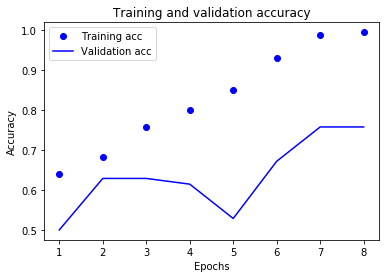

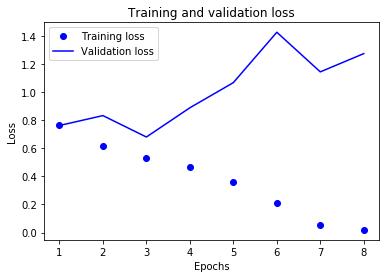

In [1548]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

In [1549]:
print("Training time" + str(time.time() - start))

Training time103.90482997894287


## Evaluation on test set

In [1550]:
results = model.evaluate(X_test, y_test)

300/300 [==============================] - 1s 3ms/step


## Save the model and tokenizer for future use

In [1551]:
model.save("HospitalErrorDetectionMultiAttributeClassifier.h5")

In [1552]:
with open('HospitalErrorDetectionMultiAttributeTokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL, fix_imports=True)

## Run model on the test dataset

In [1553]:
start = time.time()

In [1554]:
model = load_model('HospitalErrorDetectionMultiAttributeClassifier.h5')

In [1555]:
with open('HospitalErrorDetectionMultiAttributeTokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [1556]:
def classifyTuples(model, tokenizer, value):
    value = [value]
    sequences = tokenizer.texts_to_sequences(value)
    testData = pad_sequences(sequences, maxlen=maxSequenceLength)
    predictions = model.predict(testData)
    return int(predictions[0] >= 0.5)

In [1557]:
ourLabels = []

#for row in rows:
#    label = classifyTuples(model, tokenizer, row)
#    ourLabels.append(row + ':' + str(label))
for row in testSet:
    label = classifyTuples(model, tokenizer, row)
    ourLabels.append(row + ':' + str(label))

In [1558]:
len(ourLabels)

300

In [1559]:
with open('HospitalDatasetPredictions.pkl', 'wb') as f:
    pickle.dump(ourLabels, f)

In [1560]:
ourLabels = np.asarray(ourLabels)
ourLabels = ourLabels[index]

## Get only the faulty tuples

In [1561]:
with open('HospitalDatasetPredictions.pkl', 'rb') as f:
    ourLabels = pickle.load(f)

In [1562]:
errors_test = [row for row in ourLabels if row[-1] == '0']

In [1563]:
len(errors_test)

65

In [1564]:
with open('HospitalDatasetErrors.pkl', 'wb') as f:
    pickle.dump(errors_test, f)

### Convert pickle to dataframe

In [1565]:
values = [row.split(':') for row in errors_test]

In [1566]:
len(values)

65

In [1567]:
headers = df.columns.tolist()
headers.append('label')

In [1568]:
df = pd.DataFrame(values, columns=headers)

In [1569]:
df.to_csv('HospitalErrors.csv',encoding='utf8',index=False)

## Metrics

In [1570]:
from sklearn.metrics import classification_report

y_pred = []
for i in ourLabels:
    y_pred.append(int(i.split(':')[-1]))
print(classification_report(labels_test, y_pred))

             precision    recall  f1-score   support

          0       0.91      0.67      0.77        88
          1       0.88      0.97      0.92       212

avg / total       0.89      0.88      0.88       300



In [1571]:
print("Runtime:" + str(time.time()-start))

Runtime:39.645827770233154
